### Read from DB ###

In [1]:
import sqlalchemy as sql
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
engine=sql.create_engine('sqlite:///xrp_price.db')

In [3]:
engine.table_names()

['xrp_price']

In [4]:
df=pd.read_sql_table('xrp_price', con=engine, index_col='Date', parse_dates=True)
df=df.drop(columns='index')
df.head()

,Close,Volume,Ticker
Date,,,
2017-11-09,0.217488,147916992,XRP
2017-11-10,0.206483,141032992,XRP
2017-11-11,0.210430,134503008,XRP
2017-11-12,0.197339,251175008,XRP
2017-11-13,0.203442,132567000,XRP


In [5]:
df.index

DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07',
               '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11',
               '2022-08-12', '2022-08-13'],
              dtype='datetime64[ns]', name='Date', length=1739, freq=None)

<AxesSubplot:xlabel='Date'>

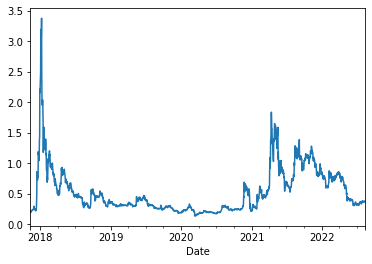

In [6]:
df['Close'].plot()

### ML ###

create a table like below: 
<img src='./images/sample_features.png' width=720>

In [7]:
features=df[['Close']]
window_size=5
for i in range(1, window_size+1): 
    features[f'Close T-{i}']=features['Close'].shift(i)

features=features.dropna()
features.head()

,Close,Close T-1,Close T-2,Close T-3,Close T-4,Close T-5
Date,,,,,,
2017-11-14,0.209825,0.203442,0.197339,0.210430,0.206483,0.217488
2017-11-15,0.212956,0.209825,0.203442,0.197339,0.210430,0.206483
2017-11-16,0.227107,0.212956,0.209825,0.203442,0.197339,0.210430
2017-11-17,0.226581,0.227107,0.212956,0.209825,0.203442,0.197339
2017-11-18,0.228627,0.226581,0.227107,0.212956,0.209825,0.203442


In [8]:
y=features[['Close']]
X=features.drop(columns=['Close'])

Split into training and testing

In [9]:
# split at 2021 / 6
X_train=X.loc[:'2021-12']
y_train=y.loc[:'2021-12']
X_test=X.loc['2022-01':]
y_test=y.loc['2022-01':]

In [10]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(1509, 5)

(225, 5)

(1509, 1)

(225, 1)

### Scale Data ###

In [11]:
from sklearn.preprocessing import MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X_train)
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

In [12]:
y_scaler=MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled=y_scaler.transform(y_train)
y_test_scaled=y_scaler.transform(y_test)

### Reshape ###

In [13]:
X_train_scaled=X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_scaled=X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

### Build Model ###

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
model=Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dense(units=1, activation='linear'))

2022-08-14 22:15:05.947421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             3840      
                                                                 
 dropout (Dropout)           (None, 5, 30)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-traina

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [18]:
model.fit(X_train_scaled, y_train_scaled, epochs=50)

Epoch 1/50
48/48 [==============================] - 4s 8ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 2/50
48/48 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/50
48/48 [==============================] - 0s 7ms/step - loss: 8.4821e-04 - mean_squared_error: 8.4821e-04
Epoch 4/50
48/48 [==============================] - 0s 7ms/step - loss: 8.4849e-04 - mean_squared_error: 8.4849e-04
Epoch 5/50
48/48 [==============================] - 0s 7ms/step - loss: 7.5506e-04 - mean_squared_error: 7.5506e-04
Epoch 6/50
48/48 [==============================] - 0s 7ms/step - loss: 7.8213e-04 - mean_squared_error: 7.8213e-04
Epoch 7/50
48/48 [==============================] - 0s 7ms/step - loss: 7.3846e-04 - mean_squared_error: 7.3846e-04
Epoch 8/50
48/48 [==============================] - 0s 7ms/step - loss: 7.2753e-04 - mean_squared_error: 7.2753e-04
Epoch 9/50
48/48 [==============================] - 0s 7ms/step - loss: 6.3893e-04 - mea

In [19]:
y_predicted=model.predict(X_test_scaled)

8/8 [==============================] - 1s 3ms/step


### Plot Prediction ###

In [20]:
import matplotlib.pyplot as plt

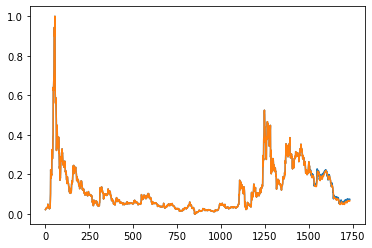

In [21]:
price=np.concatenate([y_train_scaled.ravel(), y_test_scaled.ravel()])
prediction=np.concatenate([y_train_scaled.ravel(), y_predicted.ravel()])
fig=plt.figure()
plt.plot(price)
plt.plot(prediction)

In [22]:
next_prediction_input=df.iloc[-5:]['Close'].values
next_prediction_input_scaled=X_scaler.transform([next_prediction_input])

In [23]:
next_prediction_input_scaled

array([[0.07055394, 0.07455743, 0.0744024 , 0.07422699, 0.07359979]])

In [24]:
next_prediction=model.predict([next_prediction_input_scaled])
next_prediction

1/1 [==============================] - 1s 811ms/step


array([[0.06531388]], dtype=float32)

In [25]:
y_scaler.inverse_transform(next_prediction)

array([[0.35113275]], dtype=float32)